<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
            
The Space Shuttle Reentry Problem                           
2nd version

</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Space Shuttle Reentry Problem:* We aim find the optimal trajectory of a space shuttle reentry while minimizing the angle of attack at the terminal point.
The problem is inspired from Chapter 6 of: [Constructive Methods for Initialization and Handling Mixed State-Input Constraints in Optimal Control](https://cas.mines-paristech.fr/~petit/papers/jgnc08/main.pdf).                                                        
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

In [24]:
import Pkg
Pkg.activate("..")
include("./utils.jl");
import MKL
nh=502;

  Activating project at `c:\Users\hajje\Dropbox\PC\Desktop\Stage\COTS`


## 1. Solving with JuMP <a id='jump'></a>

In [25]:
using JuMP , Ipopt
import HSL_jll
include("../Problems/JuMP/space_Shuttle_JMP_V2.jl")
SpaceSV2JMP = space_Shuttle_JMP_V2("trapezoidal";nh=nh)

set_optimizer(SpaceSV2JMP,Ipopt.Optimizer)
set_attribute(SpaceSV2JMP, "print_level", 5)
set_optimizer_attribute(SpaceSV2JMP,"tol",1e-8)
set_optimizer_attribute(SpaceSV2JMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(SpaceSV2JMP,"max_iter",1000)
set_optimizer_attribute(SpaceSV2JMP,"mu_strategy","adaptive")
set_attribute(SpaceSV2JMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(SpaceSV2JMP, "linear_solver", "ma27")
set_optimizer_attribute(SpaceSV2JMP, "print_timing_statistics", "yes")

In [26]:
println("Solving...")
optimize!(SpaceSV2JMP)
println()

Solving...
This is Ipopt version 3.14.14, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    30069
Number of nonzeros in inequality constraint Jacobian.:     1506
Number of nonzeros in Lagrangian Hessian.............:    76158

Total number of variables............................:     4016
                     variables with only lower bounds:     1004
                variables with lower and upper bounds:     2008
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3015
Total number of inequality constraints...............:      502
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      502

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.61e+03 9.57e-01   0.0 0.00e+00    -  0.00e+00 0.00e

In [27]:
# Display results
if termination_status(SpaceSV2JMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(SpaceSV2JMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(SpaceSV2JMP) == MOI.TIME_LIMIT && has_values(SpaceSV2JMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(SpaceSV2JMP))
println()


  (Local) solution found
  objective value = 0.5958723079386046



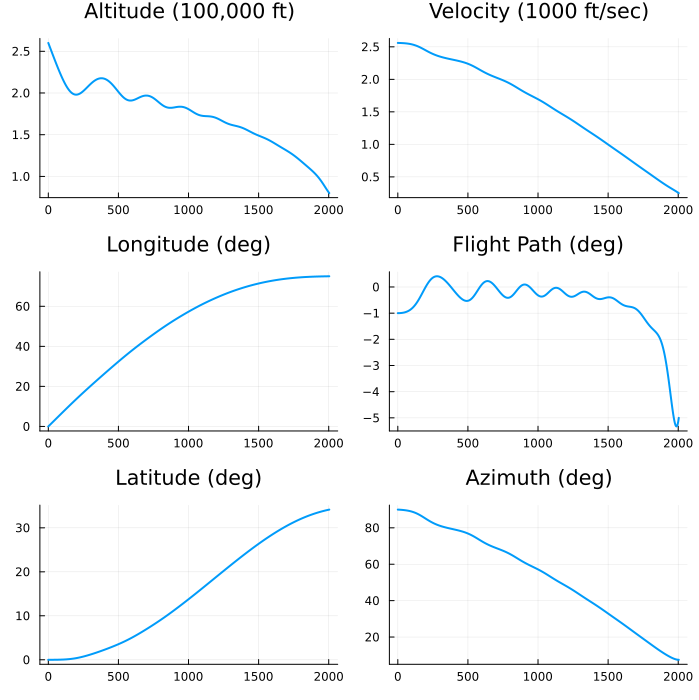

In [28]:
using Plots
scaled_h = SpaceSV2JMP[:scaled_h]
scaled_v = SpaceSV2JMP[:scaled_v]
ϕ = SpaceSV2JMP[:ϕ]
θ = SpaceSV2JMP[:θ]
γ = SpaceSV2JMP[:γ]
ψ = SpaceSV2JMP[:ψ]
Δt = SpaceSV2JMP[:Δt]
ts = cumsum([0; value.(Δt)])
plt_altitude = plot(
    ts,
    value.(scaled_h);
    legend = nothing,
    title = "Altitude (100,000 ft)",
)
plt_longitude =
    plot(ts, rad2deg.(value.(ϕ)); legend = nothing, title = "Longitude (deg)")
plt_latitude =
    plot(ts, rad2deg.(value.(θ)); legend = nothing, title = "Latitude (deg)")
plt_velocity = plot(
    ts,
    value.(scaled_v);
    legend = nothing,
    title = "Velocity (1000 ft/sec)",
)
plt_flight_path =
    plot(ts, rad2deg.(value.(γ)); legend = nothing, title = "Flight Path (deg)")
plt_azimuth =
    plot(ts, rad2deg.(value.(ψ)); legend = nothing, title = "Azimuth (deg)")

plot(
    plt_altitude,
    plt_velocity,
    plt_longitude,
    plt_flight_path,
    plt_latitude,
    plt_azimuth;
    layout = grid(3, 2),
    linewidth = 2,
    size = (700, 700),
)

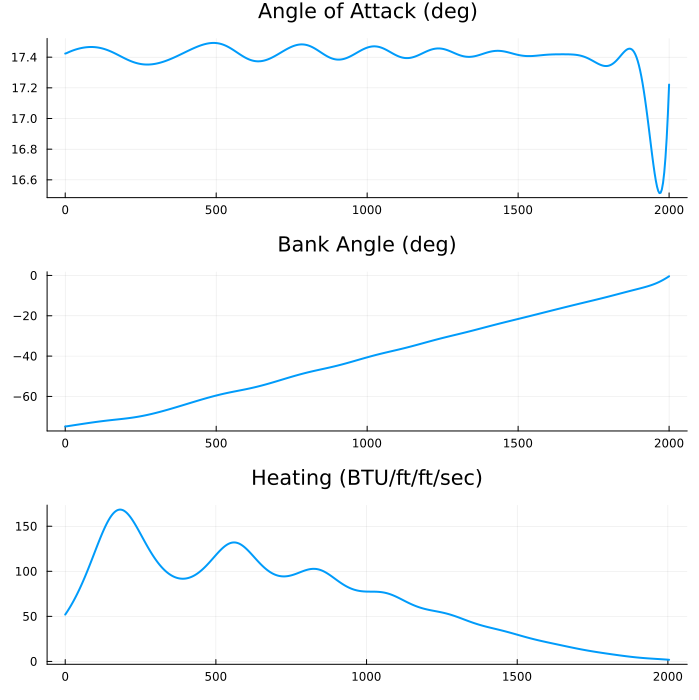

In [29]:
α = SpaceSV2JMP[:α]
β = SpaceSV2JMP[:β]
c₀ = 1.06723181
c₁ = -0.19213774e-1
c₂ = 0.21286289e-3
c₃ = -0.10117249e-5
ρ₀ = 0.002378
hᵣ = 23800.0
function q(h, v, a)
    ρ(h) = ρ₀ * exp(-h / hᵣ)
    qᵣ(h, v) = 17700 * √ρ(h) * (0.0001 * v)^3.07
    qₐ(a) = c₀ + c₁ * rad2deg(a) + c₂ * rad2deg(a)^2 + c₃ * rad2deg(a)^3
    # Aerodynamic heating on the vehicle wing leading edge
    return qₐ(a) * qᵣ(h, v)
end

plt_attack_angle = plot(
    ts[1:end-1],
    rad2deg.(value.(α)[1:end-1]);
    legend = nothing,
    title = "Angle of Attack (deg)",
)
plt_bank_angle = plot(
    ts[1:end-1],
    rad2deg.(value.(β)[1:end-1]);
    legend = nothing,
    title = "Bank Angle (deg)",
)
plt_heating = plot(
    ts,
    q.(value.(scaled_h) * 1e5, value.(scaled_v) * 1e4, value.(α));
    legend = nothing,
    title = "Heating (BTU/ft/ft/sec)",
)

plot(
    plt_attack_angle,
    plt_bank_angle,
    plt_heating;
    layout = grid(3, 1),
    linewidth = 2,
    size = (700, 700),
)

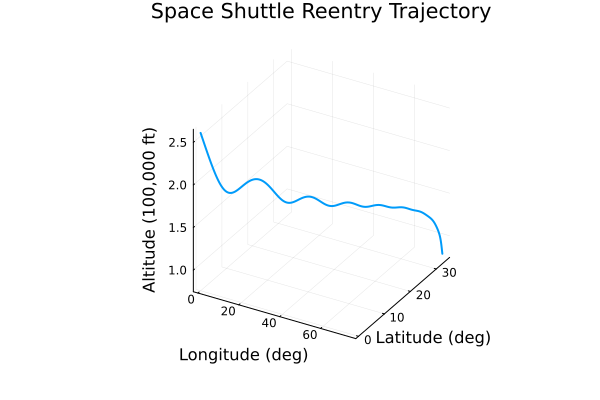

In [30]:
plot(
    rad2deg.(value.(ϕ)),
    rad2deg.(value.(θ)),
    value.(scaled_h);
    linewidth = 2,
    legend = nothing,
    title = "Space Shuttle Reentry Trajectory",
    xlabel = "Longitude (deg)",
    ylabel = "Latitude (deg)",
    zlabel = "Altitude (100,000 ft)",
)

## 2. Solving with OptimalControl <a id='oc'></a>

In [4]:
using OptimalControl
using NLPModelsIpopt
include("../Problems/OptimalControl/space_Shuttle_OC_V2.jl")
SpaceSV2OC = space_Shuttle_OC_V2();

In [12]:
# Solve the problem
import HSL_jll
init = space_Shuttle_init(;nh=nh-1)
sol = OptimalControl.solve(SpaceSV2OC, grid_size=nh-1, init =init,
        tol=1e-8, constr_viol_tol=1e-6, max_iter=1000,
        linear_solver="ma57",hsllib=HSL_jll.libhsl_path, print_timing_statistics="yes")

In [ ]:
plot(sol)

## 3. Comparison <a id='comp'></a>